In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sunxin/miniconda3/envs/qinhanmin-test/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sunxin/minico

1.13.2
2.2.4


Using TensorFlow backend.


In [2]:
import cv2
import numpy as np
from keras import layers
from keras import models
from keras.applications.resnet50 import preprocess_input, ResNet50
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Set an appropriate image file
input_image = "data/creative_commons_elephant.jpg"

################################################################
# The following parameters can be changed to other models
# that use global average pooling.
# e.g.) InceptionResnetV2 / NASNetLarge
NETWORK_INPUT_SIZE = 224
MODEL_CLASS = ResNet50
PREPROCESS_FN = preprocess_input
LAST_CONV_LAYER = 'activation_49'
PRED_LAYER = 'fc1000'
################################################################

# number of imagenet classes
N_CLASSES = 1000

In [4]:
def load_img(fname, input_size, preprocess_fn):
    # BGR -> RGB
    original_img = cv2.imread(fname)[:, :, ::-1]
    original_size = (original_img.shape[1], original_img.shape[0])
    img = cv2.resize(original_img, (input_size, input_size))
    imgs = np.expand_dims(preprocess_fn(img), axis=0)
    return imgs, original_img, original_size

In [5]:
# 1. load image
imgs, original_img, original_size = load_img(input_image,
                                             input_size=NETWORK_INPUT_SIZE,
                                             preprocess_fn=PREPROCESS_FN)

In [6]:
def get_cam_model(model_class,
                  input_size=224,
                  last_conv_layer='activation_49',
                  pred_layer='fc1000'):
    model = model_class(weights="imagenet")

    final_params = model.get_layer(pred_layer).get_weights()
    final_params = (final_params[0].reshape(1, 1, -1, N_CLASSES), final_params[1])

    last_conv_output = model.get_layer(last_conv_layer).output
    x = layers.UpSampling2D(size=(32, 32), interpolation='bilinear')(last_conv_output)
    x = layers.Conv2D(filters=N_CLASSES, kernel_size=(1, 1), name='predictions_2')(x)

    cam_model = models.Model(inputs=model.input,
                             outputs=[model.output, x])
    cam_model.get_layer('predictions_2').set_weights(final_params)
    return cam_model

In [7]:
# 2. prediction
model = get_cam_model(MODEL_CLASS,
                      NETWORK_INPUT_SIZE,
                      LAST_CONV_LAYER,
                      PRED_LAYER)
preds, cams = model.predict(imgs)

Instructions for updating:
Colocations handled automatically by placer.


In [8]:
def postprocess(preds, cams, top_k=1):
    idxes = np.argsort(preds[0])[-top_k:]
    class_activation_map = np.zeros_like(cams[0, :, :, 0])
    for i in idxes:
        class_activation_map += cams[0, :, :, i]
    return class_activation_map

In [9]:
# 4. post processing
class_activation_map = postprocess(preds, cams)

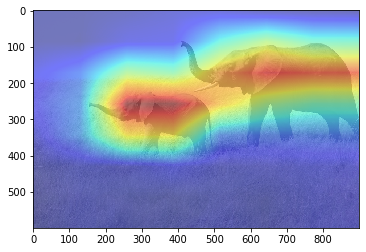

In [10]:
# 5. plot image+cam to original size
plt.imshow(original_img, alpha=0.5)
plt.imshow(cv2.resize(class_activation_map,
                      original_size), cmap='jet', alpha=0.5)
plt.show()